# Analyse und Visualisierung der Daten

# Vorbereitung

## Zugriff auf MongoDB

Es wird auf den die beiden MongoDB-Tabellen pedestrians und incidences zugegriffen, welche aus dem Import- und ETL-Schritt mittels Kafka hervorgehen.

In [1]:
from pymongo import MongoClient
import datetime as dt

client = MongoClient('mongodb://localhost:27017/')

pedestrians = client.pedcov.pedestrians
incidences = client.pedcov.incidences

## Regionen

In dem Dictionary regions werden die 6 betrachteten Regionen als Schlüssel definiert und ihnen jeweils die betrachtete Straße der Fußgängerdaten, sowie der zugehörigen Landkreis und die Einwohnerzahl des Landkreises (manuell aus dem destatis-Daten abgelesen) zugewiesen.

In [2]:
regions = {
    "München":["Kaufingerstraße, München","SK München",1488202],
    "Hamburg":["Große Bleichen, Hamburg","SK Hamburg",1852478],
    "Köln":["Ehrenstraße (Mitte), Köln","SK Köln",1083498],
    "Dresden":["Prager Straße (Nord), Dresden","SK Dresden",556227],
    "Mannheim":["Planken (Ost), Mannheim","SK Mannheim",309721],
    "Frankfurt":["Zeil (Mitte), Frankfurt a.M.","SK Frankfurt am Main",764104]
}

## Analysekriterium: Korrelation

Die Bibliothek numpy besitzt die Funktion corrcoef, welche bei Eingabe zwei gleich großer Listen die Korrelation beider Listen bestimmt. Die Funktion nimmt dabei Werte von -1 (negative Korrelation) und 1 (positive Korrelation) an. 0 bedeutet, dass die Listen nicht miteinander korrelieren.

In [3]:
# Import von numpy zur Berechnung der Korrelation zwischen zwei Variablen
import numpy as np

In [4]:
a = [0, 2, 4, 6, 9]
b = [1, 2, 3, 4, 5]

In [5]:
np.corrcoef(a, b)[0,1]

0.9958932064677037

In diesem einfachen Beispiel sieht man, dass die beiden Listen a und b, welche sich beide stetig, aber um einen anderen Faktor vergrößern, stark miteinander korrelieren.

In [6]:
import random

random.seed(10)
c = random.sample(range(0, 20), 10)
d = random.sample(range(0, 20), 10)

In [7]:
np.corrcoef(c, d)[0,1]

-0.0009221679061967371

Vergleicht man stattdessen zufällige Listen, dann gehen die Korrelationswerte gegen 0, also ist keine Korrelation anzunehmen.

### Korrelation berechnen anhand eines Dictionaries

In den folgenden Analysen treten zahlreiche dictionaries der Form 

**{datum : [Fußgängerzahl, X]}**

auf. Dabei ist X je nach Betrachtung entweder die Temperatur an dem entsprechenden Tag oder aber ein Wert in Bezug auf die Coronapandemie, wie die Fallzahl an diesem Tag oder die 7-Tage-Inzidenz, je nachdem welcher Vergleich herangezogen wird.

Mittels der Funktion `correlation(dic)` wird die Korrelation des Wertverlaufes von X mit dem Verlauf der Fußgängerzahl berechnet und zurückgegeben.

In [8]:
def correlation(dic):
    peds = [p for p,v in dic.values()]
    values = [v for p,v in dic.values()]
    return np.corrcoef(peds, values)[0,1]

## Wochenkumulierung

Da große Schwankungen zwischen einzelnen Wochentagen in den Daten vorkommen, wird mittels der Funktion das Dictionary mit Datum und Fußgängerzahl sowie einem zu vergleichen Wert X (Temperatur, Fallzahl oder Inzidenz) so angepasst, dass nur jedes siebte Datum im resultierenden Dictionary auftaucht und der Durchschnitt der Daten der vorherigen 6 Tage an diesem Datum gespeichert werden.

In [9]:
def per_week(dic):
    res = {}
    
    cur_date = dt.date(2020,1,1)
    end_date = dt.date(2020,12,31)
    
    count = 1
    sum_peds = 0
    sum_values = 0
    
    while cur_date <= end_date:
        sum_peds += dic[cur_date][0]
        sum_values += dic[cur_date][1]
        
        if count%7 == 0:
            res[cur_date] = [sum_peds, sum_values/7]
            sum_peds = 0
            sum_values = 0
        
        cur_date += dt.timedelta(days = 1)
        count += 1
        
    return res

# Analyse 1: Korrelation der Fußgänger und des Wetters

## Vorbereitung der Daten

Um die Vorkommnisse einzelner Werte in den jeweiligen Dimensionen zu zählen wird die Funktion `count_dimension` implementiert.

In [10]:
def count_date_to_temp(region):
    dic={}
    
    last_temp = 0
    
    pipeline = [{"$match": {"location": regions[region][0]}}]
    
    for row in pedestrians.aggregate(pipeline):
        if row['time of measurement'] != 'time of me':
            date = dt.datetime.strptime(row['time of measurement'], '%Y-%m-%d').date()
            temp = row['temperature in celsius']
            if temp != '':
                dic[date] = [int(row['pedestrians count']),int(temp)]
                last_temp = int(temp)
            else:
                dic[date] = [int(row['pedestrians count']),last_temp]
    return dic
count_date_to_temp("Mannheim")

{datetime.date(2020, 1, 1): [8114, 3],
 datetime.date(2020, 1, 2): [25399, 3],
 datetime.date(2020, 1, 3): [26111, 9],
 datetime.date(2020, 1, 4): [32381, 8],
 datetime.date(2020, 1, 5): [6777, 7],
 datetime.date(2020, 1, 6): [4849, 3],
 datetime.date(2020, 1, 7): [18321, 8],
 datetime.date(2020, 1, 8): [15467, 8],
 datetime.date(2020, 1, 9): [17173, 12],
 datetime.date(2020, 1, 10): [18892, 12],
 datetime.date(2020, 1, 11): [32642, 8],
 datetime.date(2020, 1, 12): [5393, 6],
 datetime.date(2020, 1, 13): [15252, 8],
 datetime.date(2020, 1, 14): [16368, 11],
 datetime.date(2020, 1, 15): [18057, 13],
 datetime.date(2020, 1, 16): [18815, 14],
 datetime.date(2020, 1, 17): [19693, 10],
 datetime.date(2020, 1, 18): [31895, 8],
 datetime.date(2020, 1, 19): [6294, 6],
 datetime.date(2020, 1, 20): [16663, 6],
 datetime.date(2020, 1, 21): [15743, 5],
 datetime.date(2020, 1, 22): [13293, 2],
 datetime.date(2020, 1, 23): [15332, 6],
 datetime.date(2020, 1, 24): [17539, 4],
 datetime.date(2020, 1, 

## Analyse 1.1: Betrachtung der Wetterlage

In [11]:
def count_dimension(dimension):
    dic = {}
    pipeline = [
        {
            "$group" : {"_id":f'${dimension}', "count":{"$sum":1}}
        }
    ]
    for row in pedestrians.aggregate(pipeline):
        dic[row['_id']] = row['count']
        
    return dic

#### Test `count_dimension`

In [12]:
count_dimension("weather condition")

{'rain': 1071,
 'wind': 13,
 'clear-day': 425,
 'partly-cloudy-day': 583,
 '': 24,
 'cloudy': 87,
 'snow': 11}

Die folgende Funktion zählt alle Fußgänger zusammen, die der spezifizierten Dimension angehören. Also beispielsweise
wie viele Fußgänger an wolkigen Tagen erfasst wurden.

In [13]:
def count_ped_per_dimension(dimension):
    dic = {}
    pipeline = [
        {
            "$group" : {"_id":f'${dimension}', "pedestrians count":{"$sum":"$pedestrians count"}}
        }
    ]
    for row in pedestrians.aggregate(pipeline):
        dic[row['_id']] = row['pedestrians count']
    return dic

#### Test `count_ped_per_dimension`

In [14]:
count_ped_per_dimension("weather condition")

{'wind': 293980,
 'rain': 27126640,
 'clear-day': 10044797,
 'partly-cloudy-day': 15506063,
 '': 0,
 'cloudy': 2356752,
 'snow': 371948}

In [15]:
def count_avg_ped_per_dimension(dimension):
    dic = {}
    pipeline = [
        {
            "$group" : {"_id":f'${dimension}', "pedestrians count":{"$sum":"$pedestrians count"}}
        }
    ]
    for row in pedestrians.aggregate(pipeline):
        dic[row['_id']] = row['pedestrians count']
        
    counts = count_dimension(dimension)
    for key in dic:
        dic[key] /= counts[key]
        dic[key] = round(dic[key],2)
    dic.pop('')
    return dic

In [16]:
import matplotlib.pyplot as plt

def plot_weather(dic,title):
    x = list(dic.keys())
    y = list(dic.values())
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    ax1.bar(x,y)
    plt.xlabel("Wetterarten")
    plt.ylabel("Durchschnittliche Fußgänger")
    fig.tight_layout()
    plt.title(title)
    plt.show()

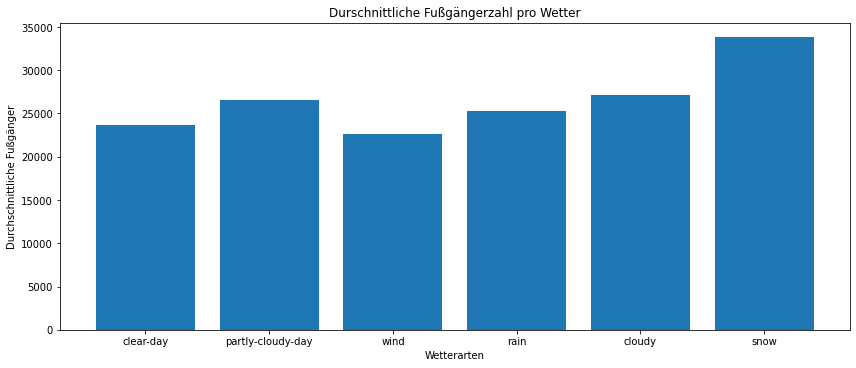

In [17]:
plot_weather(count_avg_ped_per_dimension("weather condition"),"Durschnittliche Fußgängerzahl pro Wetter")

## Analyse 1.2: Betrachtung der Temperatur

In [18]:
import matplotlib.pyplot as plt

def plot_temperature(dic,title):
    x = list(dic.keys())
    y = list(dic.values())
    
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    plt.xlabel("Temperatur in Celsius°")
    plt.ylabel("Durchschnittliche Fußgänger")
    #ax1.plot()
    ax1.scatter(x,y)
    fig.tight_layout()
    plt.title(title)
    plt.show()

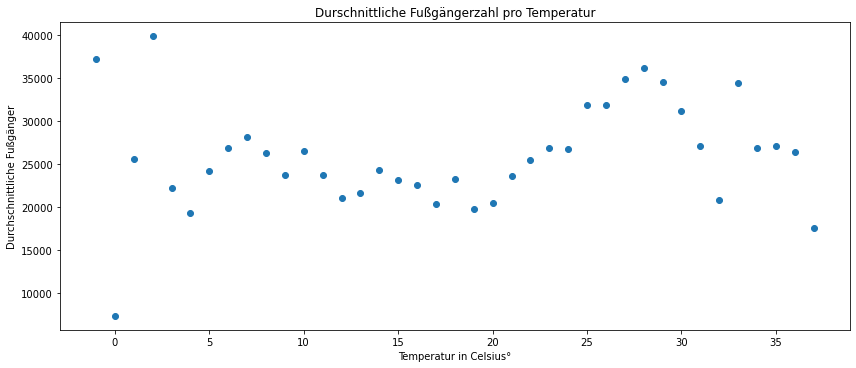

In [19]:
plot_temperature(count_avg_ped_per_dimension("temperature in celsius"),"Durschnittliche Fußgängerzahl pro Temperatur")

In [20]:
import matplotlib.pyplot as plt  

def plottimeframe_weather(date_to_temp_dic):
    x = list(date_to_temp_dic.keys())
        
    y1 = list([p for p,t in date_to_temp_dic.values()])
    y2 = list([t for p,t in date_to_temp_dic.values()])
    
    fig, ax1 = plt.subplots(figsize=(20, 5))

    ax1.set_xlabel('time')
    ax1.set_ylabel('pedestrians', color='b')
    ax1.plot_date(x, y1, linestyle='-', color='b')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('temperature', color='g')
    ax2.plot_date(x, y2, linestyle='-', color='g')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

### Mannheimer Fußgängerzahl in Relation zur Temperatur

In [21]:
weekly_date_to_temp = per_week(count_date_to_temp("Mannheim"))

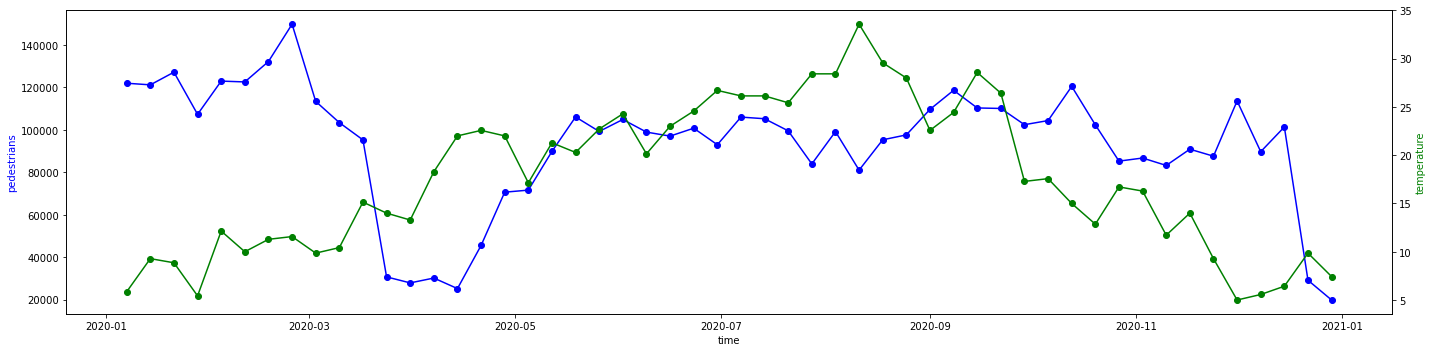

In [22]:
plottimeframe_weather(weekly_date_to_temp)

In [23]:
correlation(weekly_date_to_temp)

-0.0476566294530503

#### Reduktion auf den Pandemiezeitraum

In [24]:
start_date = dt.date(2020,3,20)

pre_weekly_date_to_temp = {}
dur_weekly_date_to_temp = {}
for date in weekly_date_to_temp:
    if date >= start_date:
        dur_weekly_date_to_temp[date] = weekly_date_to_temp[date]
    else:
        pre_weekly_date_to_temp[date] = weekly_date_to_temp[date]

Fußgängerzahl im Vergleich zur Temperatur während der Pandemie:


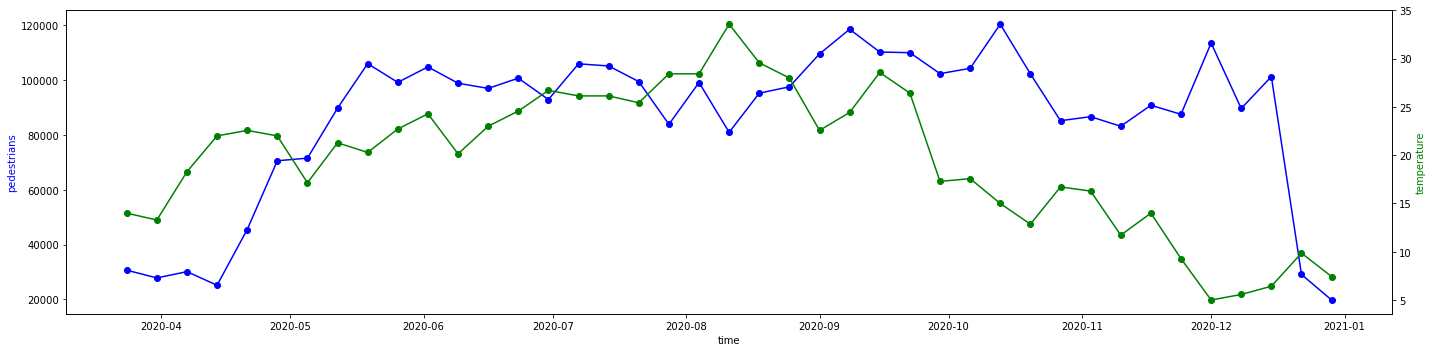

In [25]:
print("Fußgängerzahl im Vergleich zur Temperatur während der Pandemie:")
plottimeframe_weather(dur_weekly_date_to_temp)

In [26]:
print("Korrelation während der Pandemie:")
correlation(dur_weekly_date_to_temp)

Korrelation während der Pandemie:


0.2790231212096426

# Analyse 2: Korrelation der Fußgänger und der Corona-Daten

## Vorbereitung der Daten

### Dictionary mit Fußgängern und Fallzahlen bzw. Inzidenzen pro Tag

Am wichtigsten für die weitere Analyse ist es, sowohl die Anzahl an Fußgängern als auch die Summe an Coronafällen bzw. die hervorgehende Inzidenz nach Datum sortiert vorliegen zu haben. In diesem Schritt muss auch jeweils nach der betrachteten Region gefiltert werden, sofern nicht alle Regionen betrachtet werden. 

Diese Schritte sind auf die folgenden Funktionen aufgeteilt:
1. **ped_case_dic(region):** \
    Dictionary mit Fußgängern und Fallzahlen wird mittels Hilfsfunktionen aus Schritt 2 und 3 erstellt.
2. **add_peds_to_dic(dic, street)**: \
    Dem leeren Dictionary (nur mit Datum jeweils als Schlüssel) wird pro Tag die zugehörige Fußgängerzahl zugewiesen.
    Mit Hilfe des Parameters 'street' kann nach einer bestimmten Straße (Stadt) gefiltert werden.
3. **add_cases_to_dic(dic, landkreis, alter)**: \
    Dem Dictionary mit Fußgängerzahlen werden zusätzlich pro Tag die zugehörige Anzahl an Coronafällen zugewiesen.
    Mit Hilfe des Parameters 'landkreis' kann nach einem bestimmten Landkreis (Stadt) gefiltert werden.
    Zusätzlich kann mittels 'alter' eine bestimmte Altersgruppe ausgeschlossen werden (Für Betrachtung 2 wichtig).
4. **to_incidences(dic, region)**: \
    Das Dictionary wird so umgewandelt, dass die Fallzahlen durch Inzidenzen ersetzt werden.

(2. und 3. müssen vor 1. ausgeführt werden, da dies Hilfsfunktion für 1. sind)

#### 2. Fußgänger zu Dictionary hinzufügen

In [27]:
def add_peds_to_dic(dic, street):
    pipeline = []
    
    if(street):
        pipeline = [{"$match": {"location": street}}]
    
    else:
        pipeline = [{"$group": {"_id": "$time of measurement","pedestrians count": {"$sum": "$pedestrians count"}}}]
    
    for row in pedestrians.aggregate(pipeline):
        time = row['_id']
        if(street):
            time = row['time of measurement']
        date = dt.datetime.strptime(time, '%Y-%m-%d').date()
        dic[date][0] = int(row['pedestrians count'])
        
    return dic

#### 3. Fallzahlen zu Dictionary hinzufügen

In [28]:
def add_cases_to_dic(dic, landkreis, alter):
    and_case = [{"$or": [{"Neuer Fall": "0"}, {"Neuer Fall": "1"}]}]
    
    if(landkreis):
        and_case.append({"Landkreis": landkreis})
        
    if(alter):
        and_case.append({"Altersgruppe": {"$ne":alter}})
    
    pipeline = [{
                "$match": 
                    {"$and":and_case}
            },
            {
                "$group": {"_id": "$Meldedatum","Fälle": {"$sum": "$Anzahl Fall"}}
            }]
    
    for row in incidences.aggregate(pipeline):
            date = dt.datetime.strptime(row['_id'], '%Y-%m-%d').date()
            dic[date][1] = int(row['Fälle'])

    return dic

#### 1. Dictionary mit Fußgängerzahlen und Fallzahlen erstellen

In [29]:
# creates dic:  {date: [pedstrians, covid cases]}
def ped_case_dic(region,alter):
    dic = {}
    
    # initialize dictionary to have all dates in the year
    date = dt.date(2020,1,1)
    end_date = dt.date(2020,12,31)
    while date <= end_date:
        dic[date] = [None, 0]
        date += dt.timedelta(days = 1)
    
    # find out location for aggregation
    # if aggregation over alll locations, all location values are None
    street = None
    lk = None
    if(region):
        street, lk, _ = regions[region]

    # pedestrians (only München)
    dic = add_peds_to_dic(dic, street)

    # incidences (only München, NeuerFall in (0, 1)) -> aggregiert nach Meldedatum (Summe Fälle)
    dic = add_cases_to_dic(dic, lk, alter)
    
    return dic

#### 4. Umwandlung der Fälle in Inzidenzen

Die Funktion to_incidences berechnet anhand eines Dictionaries mit den einzelnen Tagen des betrachteten Zeitraumes als Schlüsseln und den dazu gehörigen Coronafällen an diesem Tag in dem betrachteten Landkreis die jeweilige 7-Tage-Inzidenz an dem jeweiligen Tag, indem die Fälle der letzten 7 Tage plus des jeweiligen Tages summiert werden und dann folgende Formel angewandt wird:

Inzidenz = (Anzahl_Fälle * 100.000) / Einwohnerzahl

Dazu nimmt die Funktion ein Dictionary der Form d = {datum: fälle} 

und gibt ein passendes dictionary res = {datum: inzidenzen} zurück.

In [30]:
def to_incidences(dic, region):
    res = {}
    
    # calculate population number
    einwohner = 0
    if(region):
        einwohner = regions[region][2]
    else:
        einwohner = sum([e for street,lk,e in regions.values()])
        
    # add the first 7 days a 0
    cur_date = dt.date(2020,1,1)
    for i in range(7):
        res[cur_date] = [dic[cur_date][0],0]
        cur_date += dt.timedelta(days = 1)
    
    for date in dic:
        if(date >= dt.date(2020,12,25)):
            break
            
        cases = 0
        cur_date = date
        cases += dic[cur_date][1]
        for delta in range(7):
            cur_date += dt.timedelta(days = 1)
            cases += dic[cur_date][1]
        
        incidence = (cases*100000)/einwohner
        res[cur_date] = [dic[cur_date][0],round(incidence)]
    
    return res

#### Test der Dictionaries jeweils ohne Aggregationseinschränkung und am Beispiel München (Datum 31.12.2020)

In [31]:
dic_cases = ped_case_dic(None, None)
l = dic_cases[dt.date(2020, 12, 31)]
print(f"Gesamte Fußgänger: {l[0]}, Coronafälle: {l[1]}")

Gesamte Fußgänger: 29777, Coronafälle: 1076


In [32]:
dic_inc = to_incidences(dic_cases,None)
l = dic_inc[dt.date(2020, 12, 31)]
print(f"Gesamte Fußgänger: {l[0]}, Inzidenz: {l[1]}")

Gesamte Fußgänger: 29777, Inzidenz: 176


In [33]:
dic_cases_mun = ped_case_dic("München", None)
l = dic_cases_mun[dt.date(2020, 12, 31)]
print(f"München Fußgänger: {l[0]}, Coronafälle: {l[1]}")

München Fußgänger: 6667, Coronafälle: 346


In [34]:
dic_inc_mun = to_incidences(dic_cases_mun,"München")
l = dic_inc_mun[dt.date(2020, 12, 31)]
print(f"München Fußgänger: {l[0]}, Inzidenz: {l[1]}")

München Fußgänger: 6667, Inzidenz: 201


## Analyse 2.1: Betrachtung des gesamten Jahres

### Visualisierungsfunktion

Mittels matplotlib werden in einem Diagramm sowohl die Fußgängerzahlen in blau als auch die Corona-Fälle bzw. -Inzidenzen in rot eingezeichnet. Auf der x-Achse befindet sich dabei die Zeit.

In [35]:
import matplotlib.pyplot as plt  

def plot(dic,corona_mode,title):
    
    x = list(dic.keys())
    
    peds = [p for p,c in dic.values()]
    corona_values = [c for p,c in dic.values()]

    y1 = list(peds)
    y2 = list(corona_values)

    fig, ax1 = plt.subplots(figsize=(12, 3))

    ax1.set_xlabel('time')
    ax1.set_ylabel('pedestrians', color='b')
    ax1.plot(x, y1, color='b')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel(corona_mode, color='r')
    ax2.plot(x, y2, color='r')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()

### Betrachtung 1: Alle Regionen

Im ersten Schritt werden die Fußgängerzahlen, Coronafälle und Inzidenzen aller betrachteten Regionen zusammen analysiert, um festzustellen, ob eine allgemeine Korrelation zwischen der Anzahl der Fußgänger und der Pandemieentwicklung festzustellen ist. 
Außerdem wird hier überprüft, ob im Allgemeinen die Fallzahl oder die 7-Tage-Inzidenz eher mit der Fußgängerzahl korreliert. 

Anschließend werden noch die jeweils wöchentlich kumulierten Daten betrachtet und die Korrelation überprüft. Diese Betrachtung hat den Vorteil, dass Wochentagsschwankungen, die besonders bei den Fußgängerzahlen hervorstechen, ausgeglichen werden sollten.

In [36]:
# Durch Eingabe von "None" wird keine Filterung nach Straße oder Landkreis durchgeführt
dic_cases = ped_case_dic(None, None)
dic_incs = to_incidences(dic_cases,None)

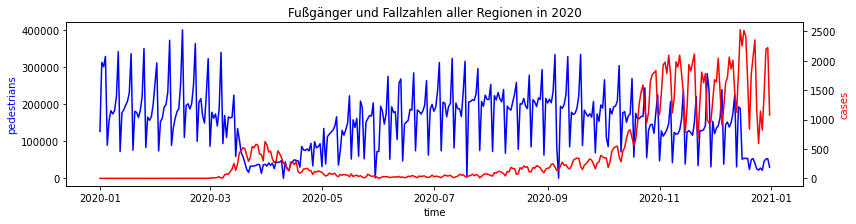

Korrelation: -0.22936050099931096


In [37]:
plot(dic_cases,"cases","Fußgänger und Fallzahlen aller Regionen in 2020")
print(f"Korrelation: {correlation(dic_cases)}")

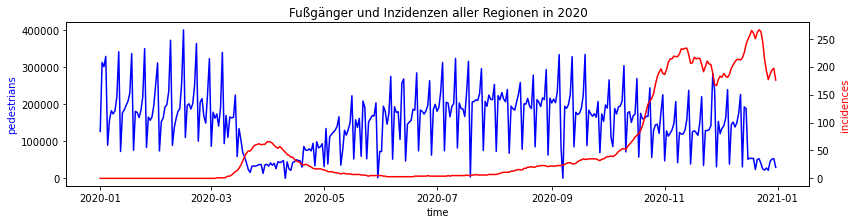

Korrelation: -0.28322215543276574


In [38]:
plot(dic_incs,"incidences","Fußgänger und Inzidenzen aller Regionen in 2020")
print(f"Korrelation: {correlation(dic_incs)}")

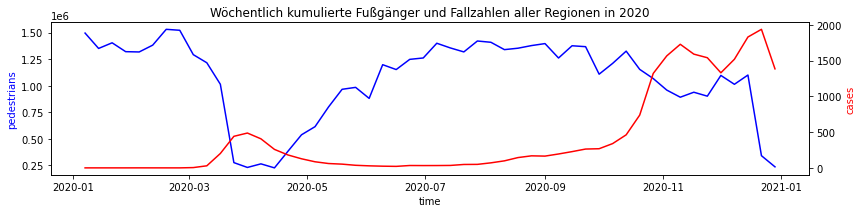

Korrelation: -0.3762490805256556


In [39]:
weekly_cases = per_week(dic_cases)
plot(weekly_cases,"cases","Wöchentlich kumulierte Fußgänger und Fallzahlen aller Regionen in 2020")
print(f"Korrelation: {correlation(weekly_cases)}")

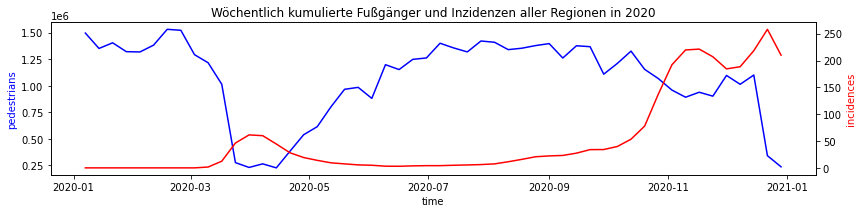

Korrelation: -0.4088844298697042


In [40]:
weekly_incs = per_week(dic_incs)
plot(weekly_incs,"incidences","Wöchentlich kumulierte Fußgänger und Inzidenzen aller Regionen in 2020")
print(f"Korrelation: {correlation(weekly_incs)}")

#### Ergebnis

Wie anhand der obigen vier Diagramme und Korrelationswerte zu erkennen ist, besteht eine unterschiedlich stark ausgeprägte negative Korrelation zwischen der Anzahl an Fußgänger und der Corona-Fallzahlen und -Inzidenzen. Das entspricht der ursprünglichen Vermutung, dass die Anzahl an Fußgängern niedriger ist, wenn mehr Menschen mit Corona erkrankt sind (und anders herum), da die Angst besteht, sich anzustecken oder stärkere Regulationen gelten.

Außerdem ist zu erkennen, dass die 7-Tage-Inzidenz im Vergleich mit der Fallzahl etwas stärker mit den Fußgängerzahlen zu korrelieren scheint, was sich durch die Einbeziehung der Einwohnerzahl begründen lässt.
Auch die jeweils wöchentlichen Kumulationen korrelieren deutlich stärker negativ miteinenander, da die wochentagsbedingten Schwankungen der Fußgänger weniger stark in die Analyse eingehen.

In den folgenden Betrachtungen werden aufgrund dieser ersten Erkenntnisse lediglich wöchentlich kumulierte Daten betrachtet, sowie ein Fokus auf die 7-Tage-Inzidenz gelegt.

### Betrachtung 2: Filterung von Kindern

Da die Anzahl an Fußgängern über Sensoren bestimmt werden, die nur mindestens 80 Zentimeter große Menschen registrieren, ist anzunehmen, dass die Korrelation nochmals ausgeprägter wird, wenn man die Corona-Fallzahlen junger Kinder herausfiltert. 

In [41]:
# Altersgruppen, die unterschieden werden:
for row in incidences.aggregate(
    [{
        "$group": {"_id": "$Altersgruppe"}
    }]):
    print(row['_id'])

A00-A04
A80+
A35-A59
A15-A34
A05-A14
A60-A79
unbekannt


Die jüngste enthaltene Altersgruppe ist demnach jene mit Menschen von 0 bis 4 Jahren.
In diesem Alter sollten unseren Vermutungen entsprechend die meisten Menschen kleiner als 80 Zentimeter sein.

In [42]:
# Anteil der Altersgruppe A00-A04 am gesamten COVID-Datensatz
num = incidences.count_documents({})
num_childs = incidences.count_documents({"Altersgruppe": "A00-A04"})
anteil = num_childs/num*100
print(f"Anteil der Altersgruppe A00-A04: {anteil} %")

Anteil der Altersgruppe A00-A04: 3.4249012227777467 %


In [43]:
dic_cases_childs = ped_case_dic(None, "A00-A04")
weekly_cases_childs = per_week(dic_cases_childs)
dic_incs_childs = to_incidences(dic_cases_childs, None)
weekly_incs_childs = per_week(dic_incs_childs)

In [44]:
def plot_with_children(dic,dic_child,corona_mode,title):
    
    x = list(dic.keys())
    
    peds = [p for p,c in dic.values()]
    corona_values = [c for p,c in dic.values()]
    corona_values_c = [c for p,c in dic_child.values()]

    y1 = list(peds)
    y2 = list(corona_values)
    y2_c = list(corona_values_c)

    fig, ax1 = plt.subplots(figsize=(12, 3))

    ax1.set_xlabel('time')
    ax1.set_ylabel('pedestrians', color='b')
    ax1.plot(x, y1, color='b')
    ax1.plot(x, y1, color='b')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel(corona_mode, color='r')
    ax2.plot(x, y2, color='r')
    ax2.plot(x, y2_c, linestyle=':', color='g')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()

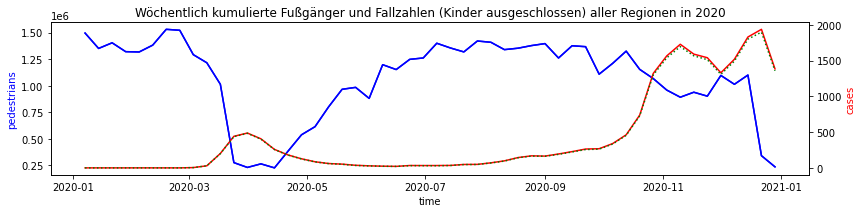

Korrelation: -0.37688145726328


In [45]:
plot_with_children(weekly_cases, weekly_cases_childs, "cases", "Wöchentlich kumulierte Fußgänger und Fallzahlen (Kinder ausgeschlossen) aller Regionen in 2020")
print(f"Korrelation: {correlation(weekly_cases_childs)}")

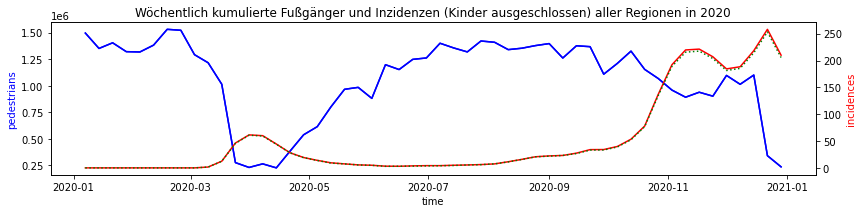

Korrelation: -0.4095680916377075


In [46]:
plot_with_children(weekly_incs, weekly_incs_childs, "incidences", "Wöchentlich kumulierte Fußgänger und Inzidenzen (Kinder ausgeschlossen) aller Regionen in 2020")
print(f"Korrelation: {correlation(weekly_incs_childs)}")

#### Ergebnis

Da die Fälle über Kinder im Alter von 0 bis 4 nur etwa 3,4 % des gesamten Corona-Datensatzes ausmachen, beeinflusst der Filter dieser Altersgruppe nur minimal die Korrelation der Fußgänger mir den Fallzahlen bzw. Inzidenzen.

Trotzdem ist eine minimal stärker negative Korrelation festzustellen, welche sich sowohl bei Betrachtung der Fallzahlen als auch der 7-Tage-Inzidenzen um etwa 0,0006 in Bezug auf den berechneten Korrelationswert auswirkt.

Da nur eine sehr minimale Erhöhung der Negativität der Korrelation erzielt wird, werden in den folgenden Betrachtungen alle Altersgruppen betrachtet.

### Betrachtung 3: Einzelne Städte

In den vorherigen Betrachtungen wurden jeweils alle Fußgängerzahlen und Corona-Daten der sechs betrachteten Städte summiert. Allerdings ist zu vermuten, dass die Korrelationen jeweils noch deutlicher werden, wenn sich jeweils auf eine Stadt fokussiert wird. Dies lässt sich dadurch begründen, dass die verschiedenen Städte sowohl sehr unterschiedliche Einwohnerzahlen haben, als auch sich in unterschiedlichen Bundesländern befinden, welche unterschiedliche Regelungen bezüglich der Pandemie getroffen haben. Außerdem hat sich das Corona-Virus nicht unbedingt gleichmäßig in ganz Deutschland verteilt.

In [47]:
cities = [c for c in regions]

city_dics_cases = []
city_dics_incs = []

for city in cities:
    city_dic_cases = ped_case_dic(city, None)
    city_dics_cases.append(city_dic_cases)
    city_dics_incs.append(to_incidences(city_dic_cases, city))

weekly_city_dics_cases = []
weekly_city_dics_incs = []

for dic in city_dics_cases:
    weekly_city_dics_cases.append(per_week(dic))

for dic in city_dics_incs:
    weekly_city_dics_incs.append(per_week(dic))

In [48]:
def plot_cities_together(cities_dics):
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    
    fig, ax1 = plt.subplots(2,1,figsize=(15, 10))

    for i in range(6):
        dic = cities_dics[i]
        
        x = list(dic.keys())
        peds = [p for p,i in dic.values()]
        incidences = [i for p,i in dic.values()]
        y1 = list(peds)
        y2 = list(incidences)
        
        ax1[0].set_xlabel('time')
        ax1[0].set_ylabel('pedestrians')
        ax1[0].plot(x, y1, color=colors[i], label=cities[i])
        ax1[0].set_title("Wöchentliche Anzahl an Fußgängern je Stadt")
        ax1[0].legend()
        
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('incidences')
        ax1[1].plot(x, y2, color=colors[i], label=cities[i])
        ax1[1].set_title("Wöchentliche Inzidenzen je Stadt")
        ax1[1].legend()

    plt.show()

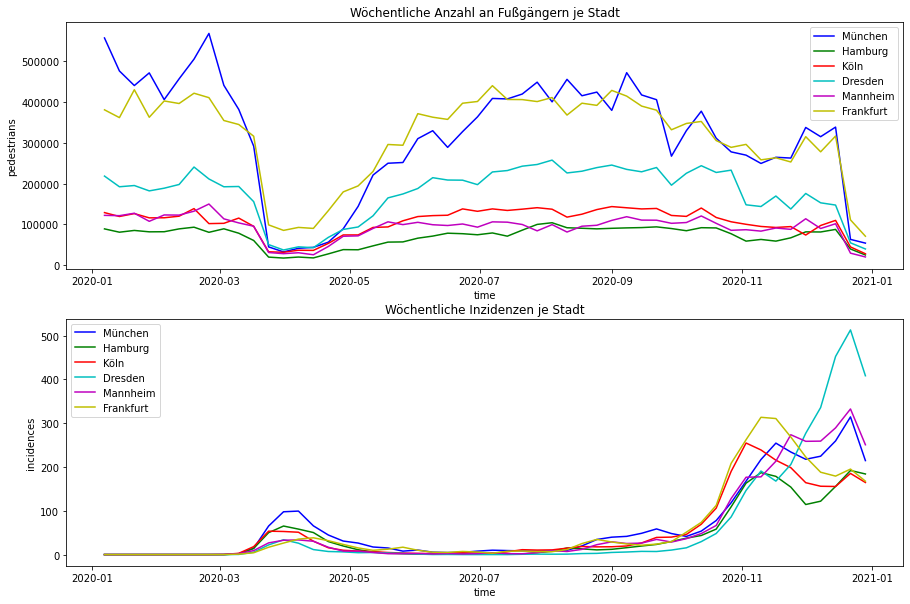

In [49]:
plot_cities_together(weekly_city_dics_incs)

In [50]:
def plot_cities_separate(cities_dics):
    
    fig, ax1 = plt.subplots(3,2,figsize=(15, 10))

    for i in range(6):
        dic = cities_dics[i]
        i1 = i%3
        i2 = i%2
        
        x = list(dic.keys())
        peds = [p for p,i in dic.values()]
        incidences = [i for p,i in dic.values()]
        y1 = list(peds)
        y2 = list(incidences)
        
        ax1[i1, i2].set_xlabel('time')
        ax1[i1, i2].set_ylabel('pedestrians', color='b')
        ax1[i1, i2].plot(x, y1, color='b')
        ax1[i1, i2].set_title(cities[i])

        ax2 = ax1[i1, i2].twinx()  # instantiate a second axes that shares the same x-axis

        ax2.set_ylabel("incidences", color='r')
        ax2.plot(x, y2, color='r')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

Fußgängeranzahl und Inzidenzen je Stadt:


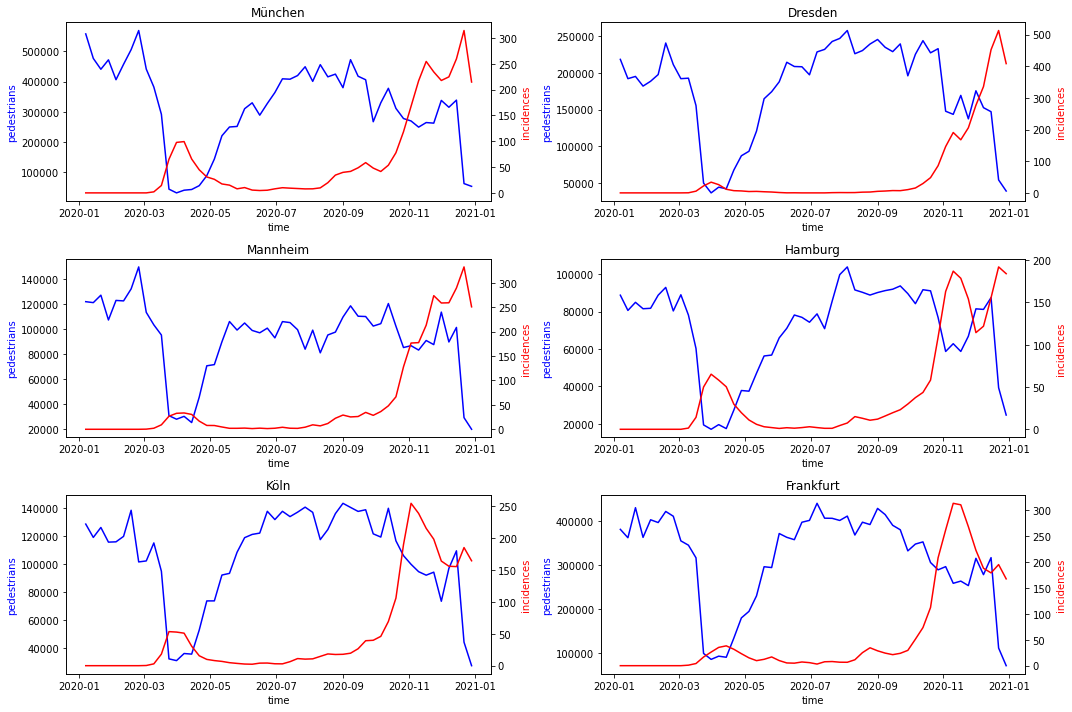

In [51]:
print("Fußgängeranzahl und Inzidenzen je Stadt:")
plot_cities_separate(weekly_city_dics_incs)

In [52]:
print("Korrelation in Bezug auf Fußgängeranzahl und Inzidenzen je Stadt:")
for i in range(6):
    cor = correlation(weekly_city_dics_incs[i])
    print(f"{cities[i]}:   \t{cor}")

Korrelation in Bezug auf Fußgängeranzahl und Inzidenzen je Stadt:
München:   	-0.4363503867725
Hamburg:   	-0.3217943635477168
Köln:   	-0.3536363500160577
Dresden:   	-0.4017744262882167
Mannheim:   	-0.3062091039781618
Frankfurt:   	-0.3373943081526115


#### Ergebnis

Entgegen der Vermutung, dass bei allen Städten jeweils die Korrelation einzeln betrachtet deutlicher sein wird als in Bezug auf alle Städte (gerundete Korrelation bei Inzidenzenbetrachtung und wöchentlicher Kumulierung: -0.409), ist dies nur bei München der Fall. Bei allen anderen Städten ist eine leicht weniger negative Korrelation festzustellen.

Dies könnte darauf hindeuten, dass für die Anzahl der Fußgänger in den einzelnen Städten die deutschlandweite Pandemieentwicklung eine größere Rolle gespielt hat als die lokale Entwicklung vor Ort. Das würde vor allem deshalb Sinn ergeben, weil die ausgewählten Städte Großstädte sind, welche durch das erhöhte Aufkommen von Reisenden stärker von globalen Reiseentwicklungen betroffen zu sein scheinen.

## Analyse 2.2: Betrachtung spezifischer Zeiträume

### Vorbereitung der Daten

In [53]:
region = "München"
dic_cases = ped_case_dic(region, None)
dic_incs = to_incidences(dic_cases,region)

In [54]:
peds = [p for p,c in dic_cases.values()]
cases = [c for p,c in dic_cases.values()]
incs = [i for p,i in dic_incs.values()]

### Grundlegende Funktionen zur Betrachtung von spezifischen Zeiträumen

Im Folgenden geht es um die Betrachtung von Fußgängerzahlen und Coronainzidenzen während spezifischen Zeiträumen im Jahr 2020. Dazu zählen Lockdowns, Ferienzeiten oder Feste wie Fastnacht. 
Dazu werden drei Funktionen definiert:

1. Die Funktionen calcDay(date) nimmt ein Datum im Format "dd-mm-yyyy" entgegen und gibt zurück, der wie vielte Tag des Jahres es ist. Dadurch kann man die relevanten Tage im Array ausmachen und für die Zeiträume zwischen Startdatum und Enddatum Visualisierungen und Analysen durchführen.


2. Die Funktion calcCor(startdate, enddate) nimmt ein Startdatum und Enddatum entgegen und berechnet mithilfe der Methode corrcoef(), ob die Fußgängeranzahl und die Coronainzidenzen in dem gewählten Zeitraum korrelieren. Das Ergebnis ist eine Zahl zwischen -1 und 1. Bei einer Zahl Nahe 0 korrelieren die Daten nicht, bei -1 handelt es sich um eine negative Korrelation und bei einem Ergebnis gegen 1 handelt es sich um eine positive Korrelation.


3. Die letzte Funktion plottimeframe(start, end) erstellt einen Graphen mit den Fußgänger- und Coronadaten für den ausgewählten Zeitraum. Auf der x-Achse befindet sich die Zeit. Auf der y-Achse befinden sich die Fußgängeranzahl (blau) und die Coronainzidenzen (rot)

In [55]:
from datetime import datetime

def calcDay(date):
    adate = datetime.strptime(date,"%d-%m-%Y")
    adate = adate.timetuple().tm_yday-1
    return adate

In [56]:
def calcCor(startdate, enddate):
    return np.corrcoef(peds[startdate:enddate+1], incs[startdate:enddate+1])

In [57]:
import matplotlib.pyplot as plt  

def plottimeframe(start, end):
    x = list(dic_cases.keys())

    x = x[start:end+1]

    y1 = list(peds[start:end+1])
    y2 = list(cases[start:end+1])
    y3 = list(incs[start:end+1])

    fig, ax1 = plt.subplots(figsize=(12, 3))

    ax1.set_xlabel('time')
    ax1.set_ylabel('pedestrians', color='b')
    ax1.plot_date(x, y1, linestyle='-', color='b')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('incidences', color='r')
    ax2.plot_date(x, y3, linestyle='-', color='r')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

### Betrachtung: 1. Lockdown März

Im Folgenden wird der erste Lockdown betrachtet. Am 27. Januar wurde der erste Coronafall in Deutschland gemeldet. Am 22. März wurde der erste Lockdown einberufen. Die Betrachtung beginnt am 01. März und endet am 1. Mai. Eine frühere Betrachtung würde keine bedeutenden Ergebnisse liefern, da zu dem Zeitpunkt kaum Fälle aufgetreten sind.
Der erste Schritt ist das Errechnen des Zeitraums mithilfe der calcDay Funktion und die Darstellung mithilfe der Bibliothek matplotlib.

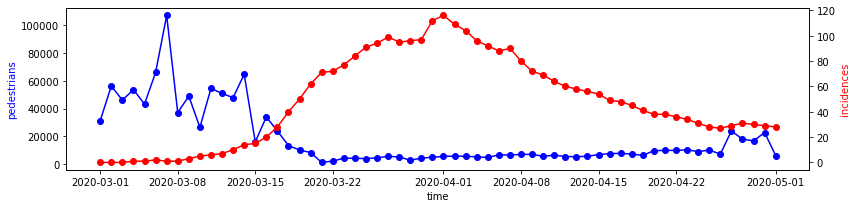

In [58]:
startdate = calcDay("01-03-2020")
enddate = calcDay("01-05-2020")
plottimeframe(startdate, enddate)

In [59]:
test = calcCor(startdate, enddate)
print(test[0,1])

-0.7248618687552083


In [60]:
startdate = calcDay("08-03-2020")
enddate = calcDay("01-04-2020")
test = calcCor(startdate, enddate)
print(test[0,1])

-0.8399894407696893


In [61]:
startdate = calcDay("01-04-2020")
enddate = calcDay("01-05-2020")
test = calcCor(startdate, enddate)
print(test[0,1])

-0.554406391643503


#### Ergebnis

Anhand der Korrelationsfunktion ist zu erkennen, dass die beiden Werte Fußgängeranzahl und Corona-Inzidenz negativ korrelieren. Daraus und anhand des obigen Graphen ist abzuleiten, dass die Fußgäger bei höherer Inzidenz wenig unterwegs waren.  

### Betrachtung: 2. Lockdown Dezember

Hier wird der zweite Lockdown betrachtet. Am 16. Dezember wurde ein starker Lockdown einberufen. Die Betrachtung beginnt am 30. November und endet am 31. Dezember. 
Der erste Schritt ist wieder das Errechnen des Zeitraums mithilfe der calcDay Funktion und die Darstellung mithilfe der Bibliothek matplotlib.

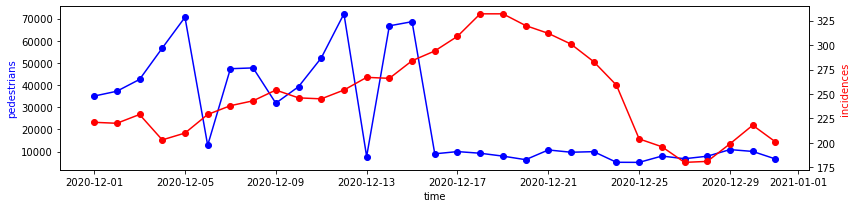

In [62]:
startdate = calcDay("01-12-2020")
enddate = calcDay("31-12-2020")
plottimeframe(startdate, enddate)

In [63]:
test = calcCor(startdate, enddate)
print(test[0,1])

-0.13163236052470295


#### Ergebnis

Anhand der Korrelationsfunktion ist zu erkennen, dass die beiden Werte Fußgängeranzahl und Corona-Inzidenz im Dezember negativ korrelieren. Anhand des Graphen ist klar zu erkennen, dass die Fußgängerzahl ab dem Lockdown am 16. Dezember drastisch gesunken ist. Mit ein wenig Verzögerug ist die Inzidenz allerdings auch gesunken und die Fußgängerzahl niedrig geblieben.

### Betrachtung: Sommerferien

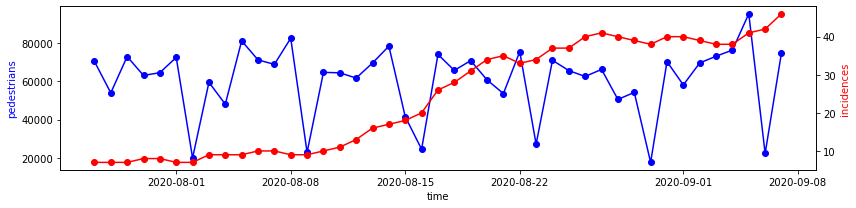

In [64]:
startdate = calcDay("27-07-2020")
enddate = calcDay("07-09-2020")
plottimeframe(startdate, enddate)

In [65]:
test = calcCor(startdate, enddate)
print(test[0,1])

0.010007532777118432


#### Ergebnis

Anhand der Korrelationsfunktion ist zu erkennen, dass die beiden Werte Fußgängeranzahl und Corona-Inzidenz kaum korrelieren. Die Inzidenzen steigen stark an während die Anzahl der Fußgänger einen recht konstanten Zyklus aufweist.   

### Betrachtung: Black Friday

Der Black Friday ist ein besonderer Einkaufstag an dem viele Geschäfte besonders hohe Rabatte und Sonderangebote bieten. Dieser fand im Jahr 2020 am 27. November statt. Dabei stellt sich die Frage, ob eine Besonderheit zu erkennen ist.
Dazu wurde das letzte Quartal beobachtet und dabei der Hochpunkt für die Fußgängerdaten ermittelt. Das Datum an dem die meisten Fußgänger erkannt wurden ist in dem Graphen mit einer grünen Senkrechten markiert.

88571
331


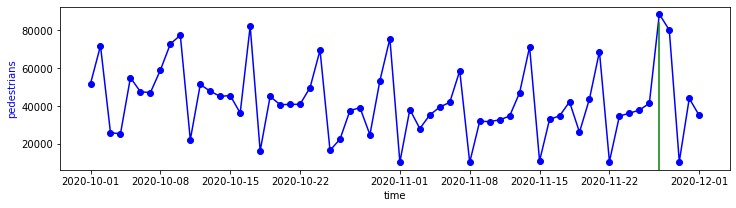

In [66]:
x = list(dic_cases.keys())
alldates = x

start = calcDay("01-10-2020")
end = calcDay("01-12-2020")
        
x = x[start:end+1]

weekend = []
for y in x:
    if(y.weekday() == 6):
        weekend.append(y)

y1 = list(peds[start:end+1])

maxped = max(peds[start:end+1])

for z in range(start,end):
    if(peds[z] == maxped):
        print(peds[z])
        maxped = z
        
fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.set_xlabel('time')
ax1.set_ylabel('pedestrians', color='b')
ax1.plot_date(x, y1, linestyle='-', color='b')

ax1.axvline(alldates[maxped], ymin=0, ymax=0.9, color="g")

print(maxped)
plt.show()

#### Ergebnis

Es ist zu erkennen, dass tatsächlich am 27. November die höchste Anzahl an Fußgängern über das vierte Quartal festgestellt wurde. Das zeigt, dass hohe Ausschläge an Tagen mit besonderen Eigenschaften wie Feiertagen oder speziellen Anreizen auftreten. Diese Besonderheit sollte man bei Analysen mit einbeziehen.

### Betrachtung: Wochenende 

Hier wird beobachtet, ob sich Unterschiede zwischen Wochentagen und dem Wochenende feststellen lassen, wenn man nur die Fußgänger betrachtet Dazu wurde beispielhaft ein Dreimonatszeitraum betrachtet und die Sonntage wurden im Graphen hervorgehoben.

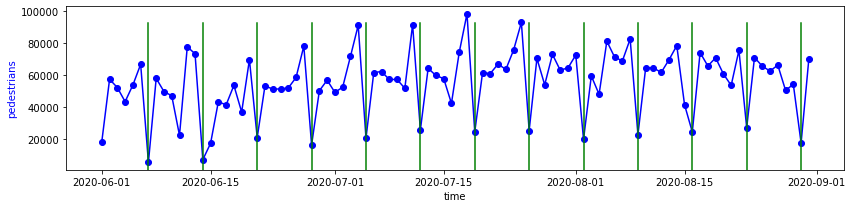

In [67]:
x = list(dic_cases.keys())

start = calcDay("01-06-2020")
end = calcDay("01-09-2020")
        
x = x[start: end]

weekend = []
for y in x:
    if(y.weekday() == 6):
        weekend.append(y)

y1 = list(peds[start:end])
y2 = list(cases[start:end])
y3 = list(incs[start:end])

fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.set_xlabel('time')
ax1.set_ylabel('pedestrians', color='b')
ax1.plot_date(x, y1, linestyle='-', color='b')
for z in weekend:
    ax1.axvline(z, ymin=0, ymax=0.9, color="g")
    
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Ergebnis

Es lässt sich feststellen, dass die Fußgängeranzahl sonntags deutlich geringer ist als an anderen Tagen. Diese Besonderheit könnte nun für weitere Analysen genutzt werden.

# Analyse 3: Vergleich der Einflüsse von Wetter und Corona-Daten

## Beispiel Mannheim

In [68]:
temp_dic = per_week(count_date_to_temp("Mannheim"))

In [69]:
inc_dic = per_week(to_incidences(ped_case_dic("Mannheim", None), "Mannheim"))

In [70]:
def plot_temp_incs(temp_dic, inc_dic):
    
    x = list(temp_dic.keys())
    
    peds = [p for p,t in temp_dic.values()]
    temps = [t for p,t in temp_dic.values()]
    incs = [i for p,i in inc_dic.values()]

    y1 = list(peds)
    y2 = list(temps)
    y3 = list(incs)

    fig, ax1 = plt.subplots(2, 1, figsize=(15, 10))

    ax1[0].set_xlabel('time')
    ax1[0].set_ylabel('pedestrians', color='b')
    ax1[0].plot(x, y1, color='b')
    ax1[0].set_title("Wöchentlich kumulierter Vergleich von Fußgängerzahlen und Temperatur in Mannheim")
    
    ax1[1].set_xlabel('time')
    ax1[1].set_ylabel('pedestrians', color='b')
    ax1[1].plot(x, y1, color='b')
    ax1[1].set_title("Wöchentlich kumulierter Vergleich von Fußgängerzahlen und Inzidenz in Mannheim")

    ax2 = ax1[0].twinx()

    ax2.set_ylabel("temperature", color='g')
    ax2.plot(x, y2, color='g')
    
    ax3 = ax1[1].twinx()

    ax3.set_ylabel("incidences", color='r')
    ax3.plot(x, y3, color='r')

    fig.tight_layout()
    plt.show()

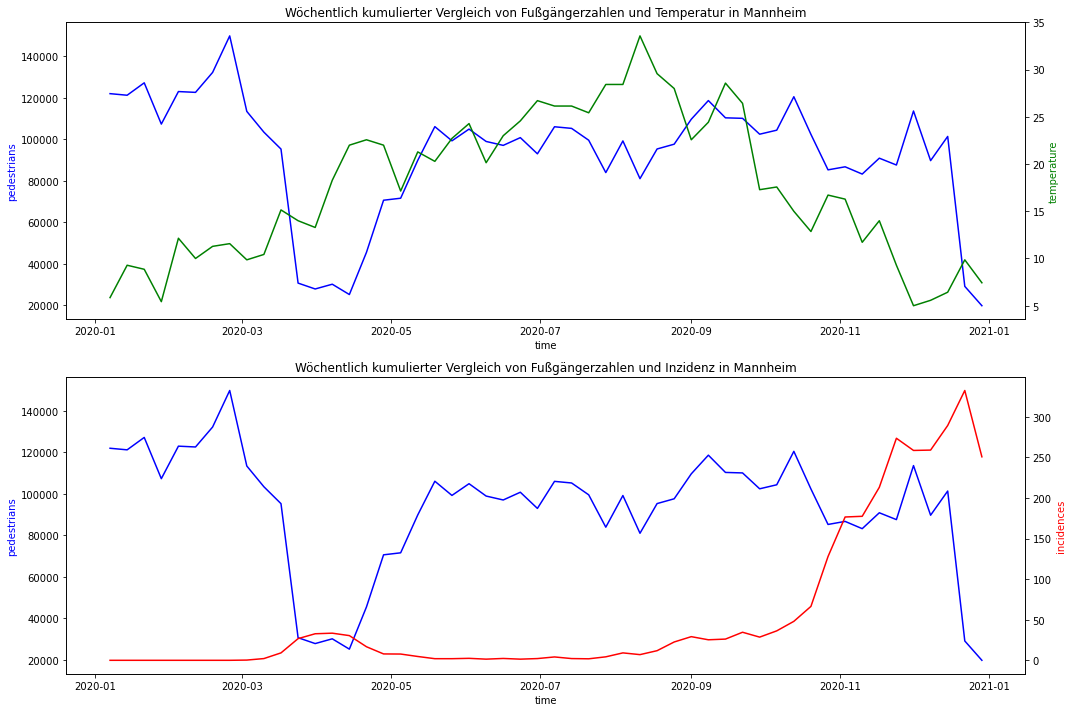

In [71]:
plot_temp_incs(temp_dic, inc_dic)

In [79]:
print("Korrelationswerte am Beispiel Mannheim in Bezug auf ...")
print(f"... Temperatur: \t{correlation(temp_dic)}")
print(f"... Inzidenz:   \t{correlation(inc_dic)}")

Korrelationswerte am Beispiel Mannheim in Bezug auf ...
... Temperatur: 	-0.0476566294530503
... Inzidenz:   	-0.3062091039781618


### Reine Betrachtung der Pandemiezeit

In [74]:
start_date = dt.date(2020,3,20)

pand_temp_dic = {date:temp_dic[date] for date in temp_dic if date >= start_date}
pand_inc_dic = {date:inc_dic[date] for date in inc_dic if date >= start_date}

In [81]:
print("Korrelationswerte am Beispiel Mannheim in der Pandemiezeit in Bezug auf ...")
print(f"... Temperatur: \t {correlation(pand_temp_dic)}")
print(f"... Inzidenz:   \t{correlation(pand_inc_dic)}")

Korrelationswerte am Beispiel Mannheim in der Pandemiezeit in Bezug auf ...
... Temperatur: 	 0.2790231212096426
... Inzidenz:   	-0.19607772562040018


### Betrachtung der Pandemiezeit im Vergleich aller Städte

In [82]:
for city in regions:
    temp_dic = per_week(count_date_to_temp(city))
    inc_dic = per_week(to_incidences(ped_case_dic(city, None), city))
    start_date = dt.date(2020,3,20)
    pand_temp_dic = {date:temp_dic[date] for date in temp_dic if date >= start_date}
    pand_inc_dic = {date:inc_dic[date] for date in inc_dic if date >= start_date}
    
    print(f"Korrelationen von {city}:")
    print(f"... Temperatur: \t {correlation(pand_temp_dic)}")
    print(f"... Inzidenz:   \t{correlation(pand_inc_dic)}")
    print(f"--------------------------------------------------------")

Korrelationen von München:
... Temperatur: 	 0.47804997260426824
... Inzidenz:   	-0.3186061200609681
--------------------------------------------------------
Korrelationen von Hamburg:
... Temperatur: 	 0.4192441503015504
... Inzidenz:   	-0.2551480790919717
--------------------------------------------------------
Korrelationen von Köln:
... Temperatur: 	 0.5528326332031471
... Inzidenz:   	-0.3222868037800264
--------------------------------------------------------
Korrelationen von Dresden:
... Temperatur: 	 0.5994077701579058
... Inzidenz:   	-0.38244420327138434
--------------------------------------------------------
Korrelationen von Mannheim:
... Temperatur: 	 0.2790231212096426
... Inzidenz:   	-0.19607772562040018
--------------------------------------------------------
Korrelationen von Frankfurt:
... Temperatur: 	 0.5598127934988881
... Inzidenz:   	-0.2592384286137431
--------------------------------------------------------


## Ergebnis

Bei Betrachtung aller Vergleiche zwischen dem Einfluss von der Temperatur im Vergleich zu der 7-Tage-Inzidenz lässt sich eindeutig erkennen, dass bei Betrachtung des gesamten Zeitraumes von 2020 die Inzidenz stärker mit der Anzahl an Fußgängern korreliert als die Temperatur. Dies liegt daran, dass die extreme Schwankung bei Beginn der Pandemie im März durch die Temperaturkurve nicht abgedeckt werden kann.

Betrachtet man hingegen die reine Pandemiezeit, hebt sich die Temperatur mit positiver Korrelation von bis zu fast 0,6 deutlich gegenüber der negativen Korrelation der Inzidenzen von bis zu fast -0,4 hervor.

Insgesamt lässt sich daraus ableiten, dass sowohl die Coronapandemie, als auch das Wetter Auswirkungen auf die Anzahl an Fußgängern auf deutschen Straßen im Jahr 2020 hatten, wobei sich dies bei der Temperatur während der Pandemie noch etwas deutlicher zeigt.

Es lassen sich also folgende Tendenzen bestätigen:

- Je höher die Temperatur, desto mehr Fußgänger sind unterwegs
- Je höher die 7-Tage-Inzidenzen, desto weniger Fußgänger sind unterwegs